# Text Analytics Data Loader

In [1]:
%load_ext autoreload
%autoreload 2

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset

# Task 1: Sentiment Classification

## Amazon Reviews

This dataset contains Amazon reviews in different languages along with their star ratings from 1 to 5. You can choose which language to work with. The code below passes the argument 'en' to load English reviews.

In [2]:
dataset = load_dataset(
    "amazon_reviews_multi", 
    'en', # Select language of the dataset
    cache_dir='./data_cache'
)

print(f'The dataset is a dictionary with two splits: \n\n{dataset}')

Reusing dataset amazon_reviews_multi (./data_cache\amazon_reviews_multi\en\1.0.0\724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609)


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 200000
    })
    validation: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['review_id', 'product_id', 'reviewer_id', 'stars', 'review_body', 'review_title', 'language', 'product_category'],
        num_rows: 5000
    })
})


The dataset already contains a test split, which we can hold out until we have tuned our method(s), and a validation split (also called 'development' set or 'devset'), as well as the training split. 

The validation set can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set (i.e., not to look at examples from the test set while developing the model) to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specific examples in the test set.

There are several approaches to validation: instead of using the presupplised validation set, you could use [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html). 

The text below loads each of the splits into a set of documents and a set of corresponding review score labels. 

In [3]:
train_documents = dataset["train"]['review_body']
print(f'Example training document: {train_documents[0]}')
train_labels = dataset["train"]['stars']
print(f'Corresponding review score: {train_labels[0]}')
print(f'Number of training instances: {len(train_documents)}')

val_documents = dataset["validation"]['review_body']
print(f'Number of validation instances: {len(val_documents)}')
val_labels = dataset["validation"]['stars']

test_documents = dataset["test"]['review_body']
print(f'Number of test instances: {len(test_documents)}')
test_labels = dataset["test"]['stars']

Example training document: Arrived broken. Manufacturer defect. Two of the legs of the base were not completely formed, so there was no way to insert the casters. I unpackaged the entire chair and hardware before noticing this. So, I'll spend twice the amount of time boxing up the whole useless thing and send it back with a 1-star review of part of a chair I never got to sit in. I will go so far as to include a picture of what their injection molding and quality assurance process missed though. I will be hesitant to buy again. It makes me wonder if there aren't missing structures and supports that don't impede the assembly process.
Corresponding review score: 1
Number of training instances: 200000
Number of validation instances: 5000
Number of test instances: 5000


The star ratings are our classes in this task:

In [4]:
import numpy as np 
print(np.unique(train_labels))

[1 2 3 4 5]


The training set is very large, so you may wish to work with a subset of the training data by using the code below:

In [5]:
from sklearn.model_selection import train_test_split

# Split test data from training data
train_documents, unused_documents, train_labels, unused_labels = train_test_split(
    train_documents, 
    train_labels, 
    test_size=0.9, 
    stratify=train_labels  # make sure the same proportion of labels is in the test set and training set
)

In [6]:
# label 0 = negative, 1 = neutral, 2 = positive
print(f'How many instances in the train dataset? \n\n{len(train_documents)}')
print('')
print(f'What does one instance look like? \n\n{train_documents[234]}')

How many instances in the train dataset? 

20000

What does one instance look like? 

Love the fragrance, but the bottle is shape makes it difficult to dispense. Shipped and described as advertised.


## Preparing Data

This step is to tokenise the text of each document and convert it to a bag of words, ready for input to a classifier. To extract a bag of words, we can use the CountVectorizer class. This class outputs the bag of words as a feature vector, where the length of the vector is equal to the size of the vocabulary, and the values are the counts of each words in a document.

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize

# CountVectorizer can do its own tokenization, but for consistency we want to
# carry on using WordNetTokenizer. We write a small wrapper class to enable this:
class Tokenizer(object):
    def __call__(self, docs):
        return word_tokenize(docs)

vectorizer = CountVectorizer(tokenizer=Tokenizer())  # construct the vectorizer

vectorizer.fit(train_documents)  # Learn the vocabulary
X_train = vectorizer.transform(train_documents)  # extract training set bags of words
X_val = vectorizer.transform(val_documents)  # extract validation set bags of words
X_test = vectorizer.transform(test_documents)  # extract test set bags of words

D:\Download\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## Naive Bayes Classifier

For our bag of words data, we use the [MultinomialNB class](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).

In [8]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, train_labels)

MultinomialNB()

Now we have a trained model, we would like to evaluate its performance on some test data.

Predict the labels for the validation set. Use X_val as the inputs to the classifier.

In [9]:
val_pred = clf.predict(X_val)

We can compute standard metrics for classifier performance using scikit-learn's metrics libary. A useful function for multi-class classification (when there are more than two classes) is the classification report function.

Compute accuracy, precision, recall and F1 scores on the validation set.

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

acc = accuracy_score(val_labels, val_pred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, val_pred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, val_pred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, val_pred, average='macro')
print(f'F1 score (macro average) = {f1}')

print(classification_report(val_labels, val_pred))

Accuracy = 0.4836
Precision (macro average) = 0.48149950136807035
Recall (macro average) = 0.48360000000000003
F1 score (macro average) = 0.48176614091588926
              precision    recall  f1-score   support

           1       0.57      0.62      0.59      1000
           2       0.38      0.38      0.38      1000
           3       0.37      0.39      0.38      1000
           4       0.43      0.37      0.40      1000
           5       0.66      0.67      0.66      1000

    accuracy                           0.48      5000
   macro avg       0.48      0.48      0.48      5000
weighted avg       0.48      0.48      0.48      5000



## Lemmatization

Lemmatization is useful for reducing the size of the vocabulary.

To apply lemmatization, we have to go back to the CountVectorizer and define a new tokenizer that will carry out the extra step of lemmatization.

In [11]:
from nltk.stem import WordNetLemmatizer 

class LemmaTokenizer(object):
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        
    def __call__(self, tweets):
        return [self.wnl.lemmatize(self.wnl.lemmatize(self.wnl.lemmatize(tok, pos='n'), pos='v'), pos='a') for tok in word_tokenize(tweets)]
    
vectorizer2 = CountVectorizer(tokenizer=LemmaTokenizer())

vectorizer2.fit(train_documents)
Xtrain = vectorizer2.transform(train_documents)
Xval = vectorizer2.transform(val_documents)
Xtest = vectorizer2.transform(test_documents)

D:\Download\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [61]:
train_documents[0]

'Just as described, works fine.Its not as good as my old shark, maybe the smaller cleaning surface is the problem. I had very high expectations for this steamer. Light weight, good cleaning capabilities, leaves surfaces fresh and hygienic, lots of accessories. Leaks water if you stay still for more than a few seconds, even in low settings, so you need to move fast.'

In [12]:
clf.fit(Xtrain, train_labels)
valpred = clf.predict(Xval)

In [13]:
acc = accuracy_score(val_labels, valpred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, valpred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, valpred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, valpred, average='macro')
print(f'F1 score (macro average) = {f1}')

print(classification_report(val_labels, valpred))

Accuracy = 0.4726
Precision (macro average) = 0.4701215045659038
Recall (macro average) = 0.4726
F1 score (macro average) = 0.47057475617585565
              precision    recall  f1-score   support

           1       0.56      0.60      0.58      1000
           2       0.36      0.36      0.36      1000
           3       0.35      0.37      0.36      1000
           4       0.43      0.36      0.39      1000
           5       0.65      0.67      0.66      1000

    accuracy                           0.47      5000
   macro avg       0.47      0.47      0.47      5000
weighted avg       0.47      0.47      0.47      5000



## N-grams

The bag of words is a very simple representation of the tweets that does not capture enough information to make accurate sentiment classifications. Another way to improve it could be to use bigrams instead of single words as our features. Bigrams are pairs of words that occur one after another in the text. Bigrams are a kind of 'n-gram', where 'n=2'.

To extract bigrams, we again modify our CountVectorizer. This class has a parameter `ngram_range`, which determines the range of sizes of n-grams the vectorizer will include. If we set `ngram_range=(1,1)` we have our standard bag of words. If we set it to `ngram_range=(2,2)`, we use bigrams instead. Choosing If we set `ngram_range=(1,2)` will use both single tokens (unigrams) and bigrams.

In [14]:
vectorizer3 = CountVectorizer(tokenizer=LemmaTokenizer(), ngram_range=(2,2))

vectorizer3.fit(train_documents)
Xtrain = vectorizer3.transform(train_documents)
Xval = vectorizer3.transform(val_documents)
Xtest = vectorizer3.transform(test_documents)

D:\Download\anaconda3\envs\data_analytics\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [15]:
clf.fit(Xtrain, train_labels)
valpred = clf.predict(Xval)

In [16]:
acc = accuracy_score(val_labels, valpred)
print(f'Accuracy = {acc}')

prec = precision_score(val_labels, valpred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(val_labels, valpred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(val_labels, valpred, average='macro')
print(f'F1 score (macro average) = {f1}')

print(classification_report(val_labels, valpred))

Accuracy = 0.4844
Precision (macro average) = 0.496537492579941
Recall (macro average) = 0.48439999999999994
F1 score (macro average) = 0.48905701530690954
              precision    recall  f1-score   support

           1       0.60      0.58      0.59      1000
           2       0.36      0.42      0.39      1000
           3       0.36      0.39      0.37      1000
           4       0.45      0.41      0.43      1000
           5       0.71      0.61      0.66      1000

    accuracy                           0.48      5000
   macro avg       0.50      0.48      0.49      5000
weighted avg       0.50      0.48      0.49      5000



## Test the model on testset

In [17]:
Ypred = clf.predict(Xtest)

acc = accuracy_score(test_labels, Ypred)
print(f'Accuracy = {acc}')

prec = precision_score(test_labels, Ypred, average='macro')
print(f'Precision (macro average) = {prec}')

rec = recall_score(test_labels, Ypred, average='macro')
print(f'Recall (macro average) = {rec}')

f1 = f1_score(test_labels, Ypred, average='macro')
print(f'F1 score (macro average) = {f1}')

print(classification_report(test_labels, Ypred))

Accuracy = 0.4822
Precision (macro average) = 0.49324143420067734
Recall (macro average) = 0.4821999999999999
F1 score (macro average) = 0.4859905380884406
              precision    recall  f1-score   support

           1       0.58      0.61      0.59      1000
           2       0.37      0.42      0.40      1000
           3       0.36      0.38      0.37      1000
           4       0.45      0.42      0.44      1000
           5       0.70      0.58      0.63      1000

    accuracy                           0.48      5000
   macro avg       0.49      0.48      0.49      5000
weighted avg       0.49      0.48      0.49      5000



## Latent Dirichlet Allocation (LDA)

### data preprocessing

To apply topic modelling, we need to first preprocess the data. We will carry out the following steps using the same approach as previous labs:
* Tokenise the posts using NLTK's word_tokenize() function
* Remove non-word tokens and tokens with length less than 3 (likely to be numbers and punctuation that are not related to specific topics) and longer than 15 (probably URLs, codes, andbadly formatted tokens rather than proper words)
* Convert the tokens to lower case
* Remove stopwords: we have not used this step before; it removes tokens such as 'the' and 'a' that appear in a list of very common words, because these words do not tell us much about topics
* Lemmatize the tokens using WordNetLemmatizer to convert verbs to their root forms

In [41]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS # find stopwords

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    # Tokenize, remove very short and very long words, convert to lower case, remove words containing non-letter characters
    for token in simple_preprocess(text) : 
        if token not in STOPWORDS:
            result.append(WordNetLemmatizer().lemmatize(token, 'v'))
            
    return result

In [65]:
# Create a list of preprocessed documents
processed = []
for i, doc in enumerate(train_documents):
    if train_labels[i] == 1 or train_labels[i] == 5:
        processed.append(preprocess(doc))

In [48]:
from gensim.corpora import Dictionary

dictionary = Dictionary(processed) # construct word<->id mappings - it does it in alphabetical order

bow_corpus = [dictionary.doc2bow(doc) for doc in processed]

We are going to try 20 topics in the document corpus. 

In [49]:
from gensim.models import LdaModel

lda_model =  LdaModel(bow_corpus, 
                      num_topics=20, 
                      id2word=dictionary,                                    
                      passes=10,
                    ) 

In [50]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.054*"love" + 0.043*"picture" + 0.031*"gift" + 0.022*"son" + 0.021*"order" + 0.021*"daughter" + 0.019*"buy" + 0.019*"beautiful" + 0.018*"year" + 0.017*"get"


Topic: 1 
Words: 0.030*"pair" + 0.027*"cheap" + 0.022*"shoe" + 0.016*"ear" + 0.015*"hole" + 0.015*"smaller" + 0.012*"feet" + 0.012*"better" + 0.012*"plastic" + 0.012*"part"


Topic: 2 
Words: 0.027*"love" + 0.024*"purchase" + 0.024*"use" + 0.022*"happy" + 0.021*"color" + 0.021*"product" + 0.021*"hair" + 0.020*"wash" + 0.018*"like" + 0.015*"smell"


Topic: 3 
Words: 0.043*"charge" + 0.032*"buy" + 0.031*"time" + 0.026*"battery" + 0.025*"work" + 0.022*"turn" + 0.022*"days" + 0.022*"months" + 0.017*"return" + 0.016*"start"


Topic: 4 
Words: 0.066*"good" + 0.050*"case" + 0.046*"price" + 0.046*"great" + 0.045*"quality" + 0.039*"phone" + 0.025*"screen" + 0.020*"product" + 0.020*"fit" + 0.019*"look"


Topic: 5 
Words: 0.042*"sound" + 0.028*"quality" + 0.020*"play" + 0.017*"phone" + 0.017*"great" + 0.016*"poor" + 0.015*

## Hierarchical Dirichlet Process (HDP)

Instead of passing in a fixed number of topics, HDP will try to learn a good number of topics to fit the data.

In [67]:
from gensim.models import HdpModel

hdp_model = HdpModel(bow_corpus, 
                     dictionary,
                     alpha=0.01,
                     gamma=0.01)

# print the word-topic distributions for 
for idx, topic in hdp_model.print_topics(20):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.008*work + 0.006*like + 0.006*great + 0.006*product + 0.006*buy + 0.005*time + 0.005*use + 0.005*good + 0.004*look + 0.004*love


Topic: 1 
Words: 0.006*like + 0.005*work + 0.005*buy + 0.004*product + 0.004*use + 0.004*love + 0.004*great + 0.004*look + 0.004*time + 0.003*good


Topic: 2 
Words: 0.002*product + 0.002*work + 0.002*like + 0.002*buy + 0.002*great + 0.002*come + 0.002*screen + 0.001*look + 0.001*love + 0.001*read


Topic: 3 
Words: 0.003*work + 0.002*buy + 0.002*time + 0.002*like + 0.002*product + 0.002*great + 0.002*use + 0.002*get + 0.002*love + 0.001*bag


Topic: 4 
Words: 0.003*like + 0.003*work + 0.002*time + 0.002*use + 0.002*buy + 0.002*good + 0.002*great + 0.002*easy + 0.002*product + 0.002*get


Topic: 5 
Words: 0.003*work + 0.002*product + 0.002*like + 0.002*great + 0.002*love + 0.002*buy + 0.002*use + 0.002*order + 0.001*fit + 0.001*need


Topic: 6 
Words: 0.002*work + 0.001*product + 0.001*like + 0.001*great + 0.001*time + 0.001*nordstrom + 0.

The previous cell shows the first 20 topics. HDP learns the number of topics that are needed to model the dataset. It produces a global distribution over the topics. Topics with very low probability can be considered inactive:

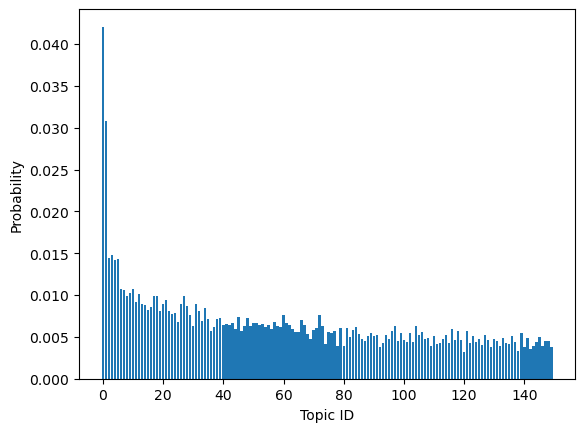

In [69]:
import matplotlib.pyplot as plt

def plot_global_topic_weights(hdp_model):
    global_topic_weights = hdp_model.m_varphi_ss / np.sum(hdp_model.m_varphi_ss)

    plt.bar(np.arange(len(global_topic_weights)), global_topic_weights)
    plt.ylabel('Probability')
    plt.xlabel('Topic ID')
    
plot_global_topic_weights(hdp_model)

# Task 2: Named Entity Recognition

## Bio Creative V

This dataset contains sentences extracted from scientific articles on PubMed. The sentences are annotated with two types of entities, chemicals and diseases. Let's load the data:

In [18]:
dataset = load_dataset(
    "tner/bc5cdr", 
    cache_dir='./data_cache'
)

print(f'The dataset is a dictionary with {len(dataset)} splits: \n\n{dataset}')

Reusing dataset bc5_cdr (./data_cache\tner___bc5_cdr\bc5cdr\1.0.0\66ea1a8c1cb0adcf8751ab7993f5d31717f21c2a9b89e21506fe959d904a7bf6)


  0%|          | 0/3 [00:00<?, ?it/s]

The dataset is a dictionary with 3 splits: 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5228
    })
    validation: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5330
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 5865
    })
})


The data is also split into train, validation and test. It may be convenient to reformat these splits into lists of tokens and lists of tags:

In [19]:
train_sentences_ner = [item['tokens'] for item in dataset['train']]
train_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['train']]

val_sentences_ner = [item['tokens'] for item in dataset['validation']]
val_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['validation']]

test_sentences_ner = [item['tokens'] for item in dataset['test']]
test_labels_ner = [[str(tag) for tag in item['tags']] for item in dataset['test']]

In [20]:
print(f'Number of training instances: {len(train_sentences_ner)}')
print(f'Number of validation instances: {len(val_sentences_ner)}')
print(f'Number of test instances: {len(test_sentences_ner)}')

print(f'Example training sentence (already tokenised): {train_sentences_ner[0]}')
print(f'...corresponding tags for the same example: {train_labels_ner[0]}')

Number of training instances: 5228
Number of validation instances: 5330
Number of test instances: 5865
Example training sentence (already tokenised): ['Naloxone', 'reverses', 'the', 'antihypertensive', 'effect', 'of', 'clonidine', '.']
...corresponding tags for the same example: ['1', '0', '0', '0', '0', '0', '1', '0']


These are the tags used to annotate the entities:

In [21]:
id2label = {
    "O": 0,
    "B-Chemical": 1,
    "B-Disease": 2,
    "I-Disease": 3,
    "I-Chemical": 4
}

label2id = {v:k for k, v in id2label.items()}
print(label2id)

{0: 'O', 1: 'B-Chemical', 2: 'B-Disease', 3: 'I-Disease', 4: 'I-Chemical'}


Put the NER data in the right format for NLTK's CRFTagger class:

In [22]:
def get_keys(d, value):
    res = []
    for val in value:
        for k, v in d.items():
            if v == val:
                res.append(k)
    return res

In [23]:
train_dataset = [list(zip(train_sentences_ner[i], get_keys(id2label, [int(tok) for tok in train_labels_ner[i]]))) for i in range(len(train_sentences_ner))][:-1]
val_dataset = [list(zip(val_sentences_ner[i], get_keys(id2label, [int(tok) for tok in val_labels_ner[i]]))) for i in range(len(val_sentences_ner))][:-1]
test_dataset = [list(zip(test_sentences_ner[i], get_keys(id2label, [int(tok) for tok in test_labels_ner[i]]))) for i in range(len(test_sentences_ner))][:-1]

Train a CRF tagger on our training set. The method you need to use from NLTK is the [train method of the conditional random field (CRF)](https://www.nltk.org/_modules/nltk/tag/crf.html). You need to call the constructor with default arguments, then the train() function.

In [24]:
import nltk

# Train a CRF NER tagger
def train_CRF_NER_tagger(train_set):
    crf = nltk.tag.CRFTagger()
    crf.train(train_set, 'model.crf.tagger')
    return crf

tagger = train_CRF_NER_tagger(train_dataset)

Get some predictions from the tagger:

In [25]:
predicted_tags_val = tagger.tag_sents(val_sentences_ner)

Let's see how well the tagger is performing. In NER, we evaluate performance by finding correctly matched entities, rather than correctly tagged tokens. Only an exact entity match counts as correct. Therefore, we need to compute precision, recall and F1 score by computing true positives, false positives and false negatives by looking for the predicted entity spans and the gold-labelled entity spans in the test set.

The code below contains a function that extract a list of spans from the tagged sentences. The next function calls extract_spans() and computes the precision, recall and f1 scores.

In [26]:
def extract_spans(tagged_sents):
    """
    Extract a list of tagged spans for each named entity type, 
    where each span is represented by a tuple containing the 
    start token and end token indexes.
    
    returns: a dictionary containing a list of spans for each entity type.
    """
    spans = {}
        
    for sidx, sent in enumerate(tagged_sents):
        start = -1
        entity_type = None
        for i, (tok, lab) in enumerate(sent):
            if 'B-' in lab:
                start = i
                end = i + 1
                entity_type = lab[2:]
            elif 'I-' in lab:
                end = i + 1
            elif lab == 'O' and start >= 0:
                
                if entity_type not in spans:
                    spans[entity_type] = []
                
                spans[entity_type].append((start, end, sidx))
                start = -1
        # Sometimes an I-token is the last token in the sentence, so we still have to add the span to the list
        if start >= 0:    
            if entity_type not in spans:
                spans[entity_type] = []
                
            spans[entity_type].append((start, end, sidx))    
            
    return spans

In [27]:
def cal_span_level_f1(test_sents, test_sents_with_pred):
    # get a list of spans from the test set labels
    gold_spans = extract_spans(test_sents)

    # get a list of spans predicted by our tagger
    pred_spans = extract_spans(test_sents_with_pred)
    
    # compute the metrics for each class:
    f1_per_class = []
    
    ne_types = gold_spans.keys()  # get the list of named entity types (not the tags)
    
    for ne_type in ne_types:
        # compute the confusion matrix
        true_pos = 0
        false_pos = 0
        
        for span in pred_spans[ne_type]:
            if span in gold_spans[ne_type]:
                true_pos += 1
            else:
                false_pos += 1
                
        false_neg = 0
        for span in gold_spans[ne_type]:
            if span not in pred_spans[ne_type]:
                false_neg += 1
                
        if true_pos + false_pos == 0:
            precision = 0
        else:
            precision = true_pos / float(true_pos + false_pos)
            
        if true_pos + false_neg == 0:
            recall = 0
        else:
            recall = true_pos / float(true_pos + false_neg)
        
        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * precision * recall / (precision + recall)
            
        f1_per_class.append(f1)
        print(f'F1 score for class {ne_type} = {f1}')
        
    print(f'Macro-average f1 score = {np.mean(f1_per_class)}')

Run the cal_span_level_F1() function below to compute span-level F1 scores for the predictions.

In [28]:
cal_span_level_f1(val_dataset, predicted_tags_val)

F1 score for class Disease = 0.65403103969235
F1 score for class Chemical = 0.8277834525025537
Macro-average f1 score = 0.7409072460974518


## Test the model on the testset

In [29]:
predicted_tags = tagger.tag_sents(test_sentences_ner)
cal_span_level_f1(test_dataset, predicted_tags)

F1 score for class Chemical = 0.815220700152207
F1 score for class Disease = 0.649018833135783
Macro-average f1 score = 0.732119766643995


We can try to help the CRF tagger by adding some more features. Part-of-speech tags often provide useful information for identifying entites. The code below defines a modified CRFTagger class that overwrites the `_get_features()` method, which extracts the features from the tokens.

In [30]:
import re, unicodedata

class CustomCRFTagger(nltk.tag.CRFTagger):
    _current_tokens = None
    
    def _get_features(self, tokens, idx):
            """
            Extract basic features about this word including
                - Current word
                - is it capitalized?
                - Does it have punctuation?
                - Does it have a number?
                - Suffixes up to length 3

            Note that : we might include feature over previous word, next word etc.

            :return: a list which contains the features
            :rtype: list(str)
            """
            token = tokens[idx]

            feature_list = []

            if not token:
                return feature_list

            # Capitalization
            if token[0].isupper():
                feature_list.append("CAPITALIZATION")

            # Number
            if re.search(self._pattern, token) is not None:
                feature_list.append("HAS_NUM")

            # Punctuation
            punc_cat = {"Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"}
            if all(unicodedata.category(x) in punc_cat for x in token):
                feature_list.append("PUNCTUATION")

            # Suffix up to length 3
            if len(token) > 1:
                feature_list.append("SUF_" + token[-1:])
            if len(token) > 2:
                feature_list.append("SUF_" + token[-2:])
            if len(token) > 3:
                feature_list.append("SUF_" + token[-3:])

            # Current word
            feature_list.append("WORD_" + token)
            
            # Previous works
            if idx != 0:
                feature_list.append("PREV_" + tokens[idx - 1])
            # Next works
            if idx != len(tokens) - 1:
                feature_list.append("NEXT_" + tokens[idx + 1])
            ####

            return feature_list

Train your custom CRF tagger, then test it below.

In [31]:
def train_CustomCRF_NER_tagger(train_set):
    CCRF = CustomCRFTagger()
    CCRF.train(train_set, 'model.crf.tagger')
    return CCRF

tagger = train_CustomCRF_NER_tagger(train_dataset)

In [32]:
predicted_tags_val = tagger.tag_sents(val_sentences_ner)
cal_span_level_f1(val_dataset, predicted_tags_val)

F1 score for class Disease = 0.6868005932317649
F1 score for class Chemical = 0.8361536123214104
Macro-average f1 score = 0.7614771027765876


In [33]:
predicted_tags = tagger.tag_sents(test_sentences_ner)
cal_span_level_f1(test_dataset, predicted_tags)

F1 score for class Chemical = 0.8206273474774134
F1 score for class Disease = 0.6917021551167892
Macro-average f1 score = 0.7561647512971013


POS tags can be used as features for tasks like NER. The code below defining another custom CRF tagger that also include POS tags as features.

In [34]:
class CRFTaggerWithPOS(CustomCRFTagger):
    _current_tokens = None
    
    def _get_features(self, tokens, index):
        """
        Extract the features for a token and append the POS tag as an additional feature.
        """
        basic_features = super()._get_features(tokens, index)
        
        # Get the pos tags for the current sentence and save it
        if tokens != self._current_tokens:
            self._pos_tagged_tokens = nltk.pos_tag(tokens)
            self._current_tokens = tokens
            
        basic_features.append(self._pos_tagged_tokens[index][1])
        
        return basic_features

In [35]:
def train_CRF_NER_tagger_with_POS(train_set):
    tagger = CRFTaggerWithPOS()
    tagger.train(train_set, 'model.crf.tagger')
    return tagger

tagger = train_CRF_NER_tagger_with_POS(train_dataset)

In [36]:
predicted_tags_val = tagger.tag_sents(val_sentences_ner)
cal_span_level_f1(val_dataset, predicted_tags_val)

F1 score for class Disease = 0.6861451460885957
F1 score for class Chemical = 0.8416180317971423
Macro-average f1 score = 0.763881588942869


In [37]:
predicted_tags = tagger.tag_sents(test_sentences_ner)
cal_span_level_f1(test_dataset, predicted_tags)

F1 score for class Chemical = 0.8257102558936128
F1 score for class Disease = 0.6874678993323061
Macro-average f1 score = 0.7565890776129595
